# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 20.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r20-0-0`.

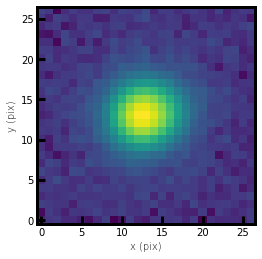

In [120]:
# Extract an image of the PSF at a random point and display it:
psf = calexp.getPsf()

xsize = calexp.getDimensions().getX()
ysize = calexp.getDimensions().getY()
# Select a random point on the image and extract the PSF at that point:
xpt = random.random()*xsize
ypt = random.random()*ysize
psfimage = psf.computeImage(geom.PointD(xpt, ypt))
img = psfimage.array

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),
                      stretch=LogStretch())

plt.imshow(img, norm=norm, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()


### Test case LVV-T38: Verify implementation of Processed Visit Images
Verify that the DMS
1. Successfully produces Processed Visit Images, where the instrument signature has been removed.
2. Successfully combines images obtained during a standard visit.

### Test case LVV-T42: Verify implementation of Processed Visit Image Content
Verify that Processed Visit Images produced by the DRP and AP pipelines include the observed data, a mask array, a variance array, a PSF model, and a WCS model.

In [1]:
# Confirm that the version of the Science Pipelines is v20_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [117]:
import lsst.daf.persistence as dafPersist
# import lsst.daf.butler as dafButler ### Gen 3 Butler
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)
import lsst.daf.persistence as dafPersist ### Gen 2 Butler (dafPersist.Butler)
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [92]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 14})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

### Load and examine some DECam difference images from HiTS

In [93]:
# Meredith pointed me to where she regularly re-runs HiTS data through diff imaging:
diffim_repo = '/project/mrawls/hits2015/rerun/cw_2020_06'

In [94]:
butler = dafPersist.Butler(diffim_repo)

In [95]:
# Pick a visit/ccd at random:
dataId = {'visit': 411406, 'ccd': 15}

# Load the calexp image
calexp = butler.get('calexp', **dataId)

# Load the raw image
raw = butler.get('raw', **dataId)

In [96]:
# Extract the images and normalize them:
im = calexp.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

rawim = raw.image.array

# Create an ImageNormalize object
rawnorm = ImageNormalize(rawim, interval=ZScaleInterval(),
                         stretch=LinearStretch())

### Compare the original image and the processed visit image (aka "calexp")

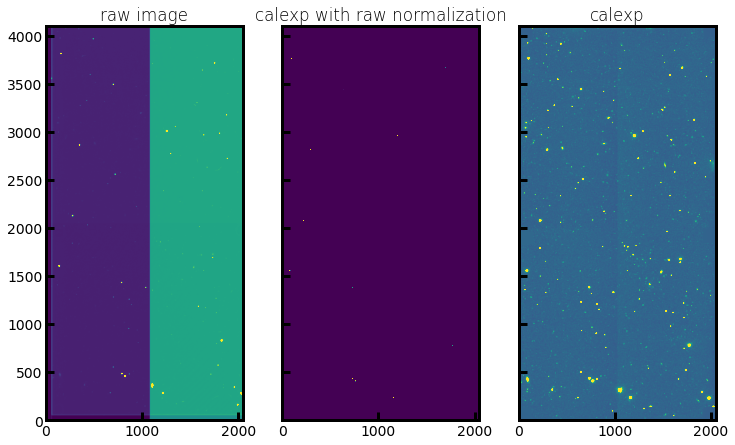

In [97]:
ncols = 3
nrows = 1
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axs = ax.flatten()

axs[0].imshow(rawim, norm=rawnorm, origin='lower')
axs[0].set_title('raw image')
axs[1].imshow(im, norm=rawnorm, origin='lower')
axs[1].set_title('calexp with raw normalization')
axs[2].imshow(im, norm=norm, origin='lower')
axs[2].set_title('calexp')
plt.show()

### Confirm that the processed visit image (aka "calexp") contains mask and variance planes

In [98]:
# Extract the images and normalize them:
mask = calexp.maskedImage

# Create an ImageNormalize object
#masknorm = ImageNormalize(mask, interval=ZScaleInterval(),
#                          stretch=LinearStretch())

# Extract the images and normalize them:
variance = calexp.variance.array

# Create an ImageNormalize object
variancenorm = ImageNormalize(variance, interval=ZScaleInterval(),
                              stretch=LinearStretch())


#### Display the variance plane:

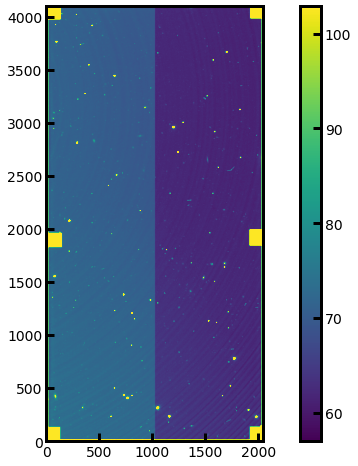

In [101]:
plt.imshow(variance, norm=variancenorm, origin='lower')
plt.colorbar()
plt.show()

#### Display the masked image:

<Figure size 936x576 with 0 Axes>

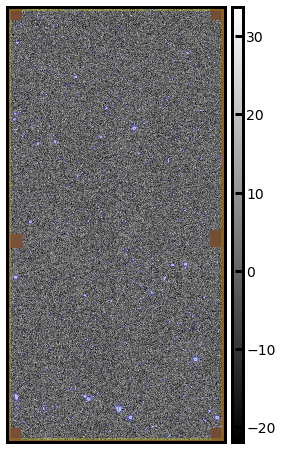

In [102]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [103]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in mask.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))


red: BAD
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


The masked image looks good and well-formed, so this portion of the test passes.

#### Confirm that the WCS is present with the calexp

In [104]:
# First, check the result of the "hasWcs" method:
calexp.hasWcs()

True

In [105]:
# OK, the Butler claims that the calexp has a WCS. Now check the WCS.

# Load the source catalog
src = butler.get('src', dataId = dataId)

# Extract the WCS+calexp and match to Gaia:
wcs = calexp.getWcs()

# Start from XY, then use the WCS to convert to RA, Dec:
xxx = src.getX()
yyy = src.getY()
radec = [wcs.pixelToSky(xxx[i], yyy[i]) for i in range(len(xxx))]

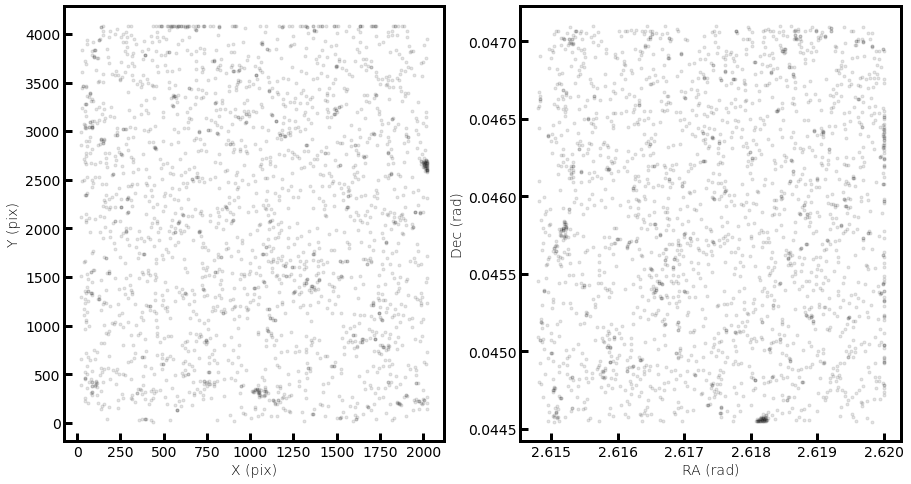

In [109]:
plt.rcParams.update({'figure.figsize' : (15, 8)})

plt.subplot(121)
plt.plot(xxx, yyy, 'k.', alpha=0.1)
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.subplot(122)
for r in radec:
    plt.plot(r.getRa(), r.getDec(), 'k.', alpha=0.1)

plt.xlabel('RA (rad)')
plt.ylabel('Dec (rad)')
plt.show()

The positions seem to have reasonably converted from (X, Y) to (RA, Dec). We thus consider this portion of the test to have passed.

#### Confirm that the PSF is available and can be extracted

In [121]:
calexp.hasPsf()

True

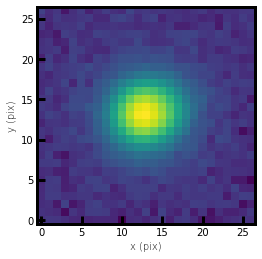

In [122]:
# Extract an image of the PSF at a random point and display it:
psf = calexp.getPsf()

xsize = calexp.getDimensions().getX()
ysize = calexp.getDimensions().getY()
# Select a random point on the image and extract the PSF at that point:
xpt = random.random()*xsize
ypt = random.random()*ysize
psfimage = psf.computeImage(geom.PointD(xpt, ypt))
img = psfimage.array

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),
                      stretch=LogStretch())

plt.imshow(img, norm=norm, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()


This is a well-formed image of a reasonable-looking PSF. We thus consider this portion of the test to have passed.

We have now confirmed that a randomly-selected Processed Visit Image (aka "calexp") has image, mask, and variance planes, and an associated WCS and PSF that behave as expected.